In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
from path import Path as p

In [2]:
PATH = "../../../data/"
PATH2 = "../../../data/Flicker8k_Dataset/"
sz=224
bs = 64
n = 1000 # Number of dogs and cats to train model on
# imbalanced classes
CATDOG = 0 # Dummy class variables
NOTCATDOG = 1 # Not Cat or Not Dog

In [3]:
def get_names(filelist, suffix):
    return [suffix + f.name for f in filelist]

In [14]:
train_cats = get_names(p(PATH + "dogscats/train/cats/").files(), "dogscats/train/cats/")
train_dogs = get_names(p(PATH + "dogscats/train/dogs/").files(), "dogscats/train/dogs/")
valid_cats = get_names(p(PATH + "dogscats/valid/cats/").files(), "dogscats/valid/cats/")
valid_dogs = get_names(p(PATH + "dogscats/valid/dogs/").files(), "dogscats/valid/dogs/")
flickr = get_names(p(PATH2).files(), str(p(p(PATH2).abspath()).name) + "/")
print(len(train_cats))
print(len(train_dogs))
print(len(valid_cats))
print(len(valid_dogs))
print(len(flickr))

11500
11500
1000
1000
8091


In [16]:
print(flickr[0:5])

[Path('Flicker8k_Dataset/1000268201_693b08cb0e.jpg'), Path('Flicker8k_Dataset/1001773457_577c3a7d70.jpg'), Path('Flicker8k_Dataset/1002674143_1b742ab4b8.jpg'), Path('Flicker8k_Dataset/1003163366_44323f5815.jpg'), Path('Flicker8k_Dataset/1007129816_e794419615.jpg')]


## Part 1: Not Cats

In [17]:
def prep(train, valid):
    p(PATH + "/tmp/").rmtree_p() # remove cached training data
    animals = list(np.random.choice(train, n, False)) + list(valid)
    notanimals = list(np.random.choice(flickr, n + len(valid), False))
    fn = animals + notanimals
    yy = np.array([CATDOG]*len(animals) + [NOTCATDOG]*len(notanimals))
    cs = list(set(yy))
    v_cat_dog_idx = range(n, n + len(valid))
    v_not_idx = range(len(animals) + n, len(fn))
    vi = list(v_cat_dog_idx) + list(v_not_idx)
    return (fn, yy, cs, vi)

# fn or fnames: file names
# yy or y: numpy array which contains target labels ordered by filenames.
# cs or classes: a list of all labels/classifications, [0, 1]
# vi or val_idxs: index of images to be used for validation.

In [18]:
fnames, y, classes, val_idxs = prep(train_cats, valid_cats)

In [19]:
# Let's set up our model using the pretrained Resnet34 Imagenet model
arch=resnet34
data = ImageClassifierData.from_names_and_array(PATH, fnames, y, classes, \
                                                val_idxs, bs=bs, \
                                                tfms=tfms_from_model(arch, sz))
learn = ConvLearner.pretrained(arch, data, precompute=True)

100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:36<00:00,  1.13s/it]


In [20]:
# Use a learning rate of 0.01 and train for 5 epochs
lr = 0.01
epochs = 5
learn.fit(lr, epochs)

epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.137522   0.02288    0.9935    
    1      0.067569   0.016657   0.995                                                                                 
    2      0.047307   0.015207   0.9945                                                                                
    3      0.031811   0.014908   0.9945                                                                                
    4      0.025388   0.014355   0.994                                                                                 



[array([0.01435]), 0.994]

In [21]:
# Create our prediction function
def predict(learner, pred_files, tfs = tfms_from_model(arch, sz)):
    orig_precompute = learner.precompute
    learner.precompute = False
    trn_tfms, val_tfms = tfs
    ds = FilesIndexArrayDataset(list(pred_files), np.zeros(len(pred_files)), val_tfms, PATH)
    dl = DataLoader(ds)
    log_preds = learner.predict_dl(dl)
    preds = np.exp(log_preds)
    results = np.argmax(preds, axis=1)
    learner.precompute = orig_precompute
    return results

In [22]:
# Now try to predict on dogs
pred_dogs = predict(learn, valid_dogs)
print(sum(pred_dogs))

829


## Part 2: Not Dogs

In [23]:
fnames, y, classes, val_idxs = prep(train_dogs, valid_dogs)

In [24]:
# Let's set up our model using the pretrained Resnet34 Imagenet model
arch=resnet34
data = ImageClassifierData.from_names_and_array(PATH, fnames, y, classes, \
                                                val_idxs, bs=bs, \
                                                tfms=tfms_from_model(arch, sz))
learn = ConvLearner.pretrained(arch, data, precompute=True)

100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:33<00:00,  1.04s/it]


In [25]:
# Use a learning rate of 0.01 and train for 5 epochs
lr = 0.01
epochs = 5
learn.fit(lr, epochs)

epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.307277   0.115905   0.954     
    1      0.187187   0.087489   0.9675                                                                                
    2      0.141887   0.091784   0.968                                                                                 
    3      0.108255   0.071746   0.9755                                                                                
    4      0.08914    0.069125   0.9755                                                                                



[array([0.06912]), 0.9755]

In [26]:
# Now try to predict on cats
pred_cats = predict(learn, valid_cats)
print(sum(pred_cats))

165


## Part 3: Improve our "Not Dog" classifier

In [27]:
fnames, y, classes, val_idxs = prep(train_dogs, valid_dogs)

In [28]:
arch=resnet34
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on,\
                                        max_zoom=1.1)
data = ImageClassifierData.from_names_and_array(PATH, fnames, y, classes, \
                                                val_idxs, bs=bs, \
                                                tfms=tfms)
learn = ConvLearner.pretrained(arch, data, precompute=True)

100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:26<00:00,  1.21it/s]


In [29]:
learn.lr_find()

 94%|█████████████████████████████████████████████████████████████████▋    | 30/32 [00:00<00:00, 53.29it/s, loss=0.847]


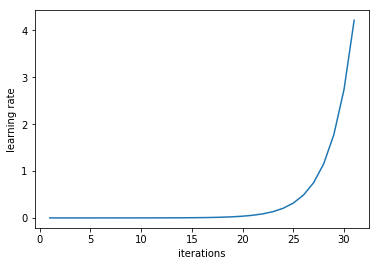

In [30]:
learn.sched.plot_lr()

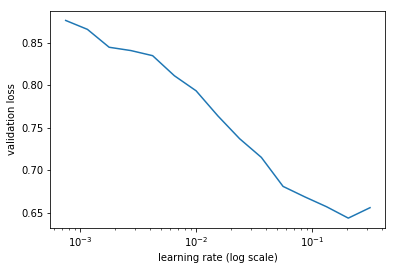

In [31]:
learn.sched.plot()

In [32]:
lr = 0.1

In [33]:
epochs = 5
learn.fit(lr, epochs)

epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.263797   0.131395   0.969     
    1      0.201868   0.076869   0.9775                                                                                
    2      0.162154   0.079309   0.978                                                                                 
    3      0.132985   0.094335   0.977                                                                                 
    4      0.110291   0.096537   0.9775                                                                                



[array([0.09654]), 0.9775]

In [34]:
learn.precompute = False

In [35]:
learn.fit(lr, 3, cycle_len = 1)

epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.172541   0.097685   0.9755    
    1      0.147458   0.098173   0.9745                                                                                
    2      0.128274   0.103721   0.974                                                                                 



[array([0.10372]), 0.974]

In [36]:
learn.unfreeze()

In [37]:
learn.lr_find()

 72%|██████████████████████████████████████████████████▎                   | 23/32 [00:43<00:17,  1.89s/it, loss=0.339]

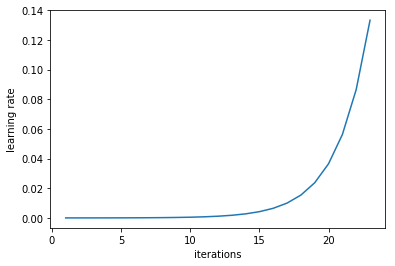

In [38]:
learn.sched.plot_lr()

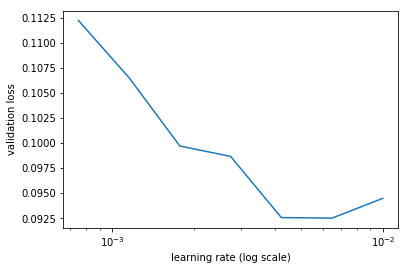

In [39]:
learn.sched.plot()

In [40]:
lr = np.array([1e-5, 1e-4, 1e-3])

In [ ]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.136758   0.118224   0.9685    


In [56]:
# Now try to predict on cats
pred_cats = predict(learn, valid_cats)
print(sum(pred_cats))

384
